# Actions and Orbit caluclation with MC sampling for GALAH DR3

## Author: Sven Buder

### History:
201204 SB Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
from astropy.table import Table, join
from scipy.io.idl import readsav
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{color}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

# 1) How to get the new Gaia eDR3 results

In [2]:
# galah_dr3 = Table.read('../../catalogs/GALAH_DR3_main_allspec_v1.fits')
# galah_dr3_ids = Table()
# galah_dr3_ids['star_id'] = galah_dr3['star_id']
# galah_dr3_ids['sobject_id'] = galah_dr3['sobject_id']
# galah_dr3_ids['source_id'] = galah_dr3['source_id']
# galah_dr3_ids.write('GALAH_DR3_main_allspec_v1_ids.csv')

Upload this table to the Gaia Archive (https://gea.esac.esa.int/archive/) and name it "GALAH_DR3_main_allspec_v1_ids"

As long as no Gaia eDR3 <-> 2MASS crossmatch is available, use the workaround via Gaia eDR3 <-> Gaia DR2 source_ids:

```ADQL
SELECT galah_dr3_ids.star_id,galah_dr3_ids.sobject_id,edr3_dr2.*,gaiaedr3.*
FROM
    gaiaedr3.gaia_source as gaiaedr3
JOIN
    gaiaedr3.dr2_neighbourhood AS edr3_dr2
    ON gaiaedr3.source_id = edr3_dr2.dr3_source_id
JOIN
    user_sbuder.GALAH_DR3_main_allspec_v1_ids AS galah_dr3_ids
    ON edr3_dr2.dr2_source_id = galah_dr3_ids.source_id
```

Download as FITS named "Gaia_eDR2_to_GALAH_DR3_via_Gaia_DR2_onesided.fits"

There are multiple entries in Gaia eDR3 for some DR2 entries!

# 2) Calculate Lindegren2020 Parallax Zeropoint

In [3]:
from zero_point import zpt
zpt.load_tables()

In [4]:
data = Table.read('Gaia_eDR3_to_GALAH_DR3_via_Gaia_DR2_onesided.fits')
data_zpt = Table()
data_zpt['sobject_id'] = data['sobject_id']
data_zpt['dr2_source_id'] = data['dr2_source_id']
data_zpt['dr3_source_id'] = data['dr3_source_id']
data_zpt['angular_distance'] = data['angular_distance']

In [5]:
aparam_31_95 = (data['astrometric_params_solved'] == 31) | (data['astrometric_params_solved'] == 95)

In [6]:
lindegren2020_zpt = zpt.get_zpt(
    phot_g_mean_mag = data['phot_g_mean_mag'][aparam_31_95],
    nu_eff_used_in_astrometry = data['nu_eff_used_in_astrometry'][aparam_31_95],
    pseudocolour = data['pseudocolour'][aparam_31_95],
    ecl_lat = data['ecl_lat'][aparam_31_95],
    astrometric_params_solved = data['astrometric_params_solved'][aparam_31_95]
)

/Users/svenbuder/anaconda3/lib/python3.7/site-packages/gaiadr3_zeropoint-0.0.2-py3.7.egg/zero_point/zpt.py:208: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  UserWarning)
/Users/svenbuder/anaconda3/lib/python3.7/site-packages/gaiadr3_zeropoint-0.0.2-py3.7.egg/zero_point/zpt.py:223: UserWarning: The nu_eff_used_in_astrometry of some of the 5p source(s) is outside the expected range (1.1-1.9 
                mag). Outside this range, the zero-point calculated can be seriously wrong.
  UserWarning)
/Users/svenbuder/anaconda3/lib/python3.7/site-packages/gaiadr3_zeropoint-0.0.2-py3.7.egg/zero_point/zpt.py:236: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  UserWarning)


In [7]:
data_zpt['zpt_ll2020'] = np.zeros(len(data['parallax']))
data_zpt['zpt_ll2020'][aparam_31_95] = lindegren2020_zpt
data_zpt['zpt_ll2020'][~aparam_31_95] = np.nan
data_zpt['parallax_corr'] = data['parallax'] - data_zpt['zpt_ll2020']
data_zpt.write('zpt_ll2020.fits',overwrite=True)

# 3) Match individual catalogs

Load GALAH_DR3_main_allspec_v1.fits in TOPCAT (Table 1). Select only star_id and sobject_id

Load Gaia_eDR2_to_GALAH_DR3_via_Gaia_DR2_onesided.fits into TOPCAT (Table 2).
Sort this table "angular_distance" (this way we select the closest match for each of Gaia eDR3 with respect to Gaia DR2).

Load zpt_ll2020.fits into TOPCAT (Table 3).
Sort this table "angular_distance" (this way we select the closest match for each of Gaia eDR3 with respect to Gaia DR2).

X-match Table 1 (GALAH DR3) and Table 2 (Gaia eDR3 x-match) via "Exact Value" column "sobject_id" with "Best match for each Table 1 row" and "All from 1".

X-match Table 4 (GALAH DR3 + Gaia eDR3) and Table 3 (ZPT) via "Exact Value" column "sobject_id_1"/"sobject_id" with "Best match for each Table 1 row" and "All from 1".

Rename column "*_1" -> "*" for star_id, sobject_id, dr2_source_id, dr3_source_id and deselect the entries 107-110.

“[…] the bias function Z5 or Z6 should be subtracted from the value (parallax) […]” (https://ui.adsabs.harvard.edu/abs/2020arXiv201201742L).

If wanted: add the Description and UCD for the parallax zeropoint bias:

zpt_ll2020:  
Description: Parallax Zeropoint following Lindegren2020 arXiv:2012.01742  
Unit: mas  
UCD: stat.error;pos.parallax.trig  

parallax_corr:  
Description: parallax corrected by subtracting zpt_ll2020  
Unit: mas  
UCD: pos.parallax.trig  

Save as "VAC_Gaia_eDR3_to_GALAH_DR3_via_Gaia_DR2.fits"

In [5]:
data = Table.read('../../catalogs/GALAH_DR3_VAC_GaiaEDR3_v2.fits')

In [6]:
header = pyfits.getheader('../../catalogs/GALAH_DR3_VAC_GaiaEDR3_v2.fits',1)

In [7]:
galah_wiki_schema = [
    ['*Column Name* | *Units* | *Description* | *Data Type* | '],
    [':--------------|:--------------|:------------|:----------|']
]

for each_index,each_key in enumerate(data.keys()):
    units = ''
    if 'TUNIT'+str(each_index+1) in header.keys():
        unit = header['TUNIT'+str(each_index+1)]
    description = ''
    if 'TCOMM'+str(each_index+1) in header.keys():
        description = header['TCOMM'+str(each_index+1)]
    galah_wiki_schema.append([each_key+'|'+units+'|'+description+'|'+str(data[each_key].dtype)+'|'])
np.savetxt('dr3_vac_gaia_edr3_via_gaia_dr2.txt',np.array(galah_wiki_schema),fmt='%s')

# 2) Check out what changed

In [2]:
galah_dr3 = Table.read('../../catalogs/GALAH_DR3_main_allspec_v1.fits')
vac_gaia_edr3 = Table.read('VAC_Gaia_eDR3_to_GALAH_DR3_via_Gaia_DR2.fits')

vac_gaia_edr3['parallax_orig'] = vac_gaia_edr3['parallax']
vac_gaia_edr3['parallax'] = vac_gaia_edr3['parallax'] + vac_gaia_edr3['zpt_ll2020']

In [3]:
galah_dr3_gaia_edr3 = join(
    galah_dr3,
    vac_gaia_edr3, 
    keys='sobject_id', 
    table_names=['dr2','edr3'], 
    metadata_conflicts='silent'
)

In [4]:
def plot_density(x, y, bins=100, range=None, normed=False, weights=None, 
                 scaling=None, reduce_fn='sum', smooth=0, ax=None, cmin=0, **kwargs):
    """
    Compute the bi-dimensional histogram of two data samples.

    Parameters
    ----------
    x : array_like, shape (N,)
        An array containing the x coordinates of the points to be
        histogrammed.
    y : array_like, shape (N,)
        An array containing the y coordinates of the points to be
        histogrammed.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:

        * If int, the number of bins for the two dimensions (nx=ny=bins).
        * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
        * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
        * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
        * A combination [int, array] or [array, int], where int
            is the number of bins and array is the bin edges.

    range : array_like, shape(2,2), optional
        The leftmost and rightmost edges of the bins along each dimension
        (if not specified explicitly in the `bins` parameters):
        ``[[xmin, xmax], [ymin, ymax]]``. All values outside of this range
        will be considered outliers and not tallied in the histogram.
    normed : bool, optional
        If False, returns the number of samples in each bin. If True,
        returns the bin density ``bin_count / sample_count / bin_area``.
    weights : array_like, shape(N,), optional
        An array of values ``w_i`` weighing each sample ``(x_i, y_i)``.
        Weights are normalized to 1 if `normed` is True. If `normed` is
        False, the values of the returned histogram are equal to the sum of
        the weights belonging to the samples falling into each bin.
    """
    import pylab as plt
    from scipy.ndimage import gaussian_filter

    ind = (np.isfinite(x) & np.isfinite(y))
    if False in ind:
        print("Warning: Not all values are finite.")
        w = weights
        if w is not None:
            w = w[ind]
        n, bx, by = plt.histogram2d(x[ind], y[ind], bins=bins, range=range, normed=normed,
                                    weights=w)
    else:
        n, bx, by = plt.histogram2d(x, y, bins=bins, range=range, normed=normed,
                                    weights=weights)

    if reduce_fn.lower() in ('average', 'mean', 'avg'):
        n0, _, _ = plt.histogram2d(x, y, bins=bins, range=range, normed=normed,
                                   weights=None)
        
        cmin_limit = (n0 < cmin)
        ind = n0 > 0
        n = n.astype(float)
        n[ind] /= n0[ind].astype(float)
    n[(n==0)] = np.nan
    n[cmin_limit] = np.nan

    defaults = dict(zorder = 2, cmap='RdYlBu_r', origin='lower', aspect='auto', rasterized=True,
                    interpolation='nearest')
    defaults.update(**kwargs)
    extent = (bx[0], bx[-1], by[0], by[-1])

    if smooth > 0:
        gaussian_filter(n, smooth, output=n)

    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
        
    if scaling is None:
        scaling = 'None'
    s = scaling.lower().replace(' ', '')
    if s in (None, 'none', 'count'):
        return ax.imshow(n.T, extent=extent, **defaults)#, n
    else:
        if s in ('log', 'log(n)', 'log10', 'log(count)'):
            return ax.imshow(np.log10(n).T, extent=extent, **defaults)#, np.log10(n)
        elif s in ('log(n+1)', 'log(count+1)'):
            return ax.imshow(np.log10(n + 1).T, extent=extent, **defaults)#, np.log10(n + 1)

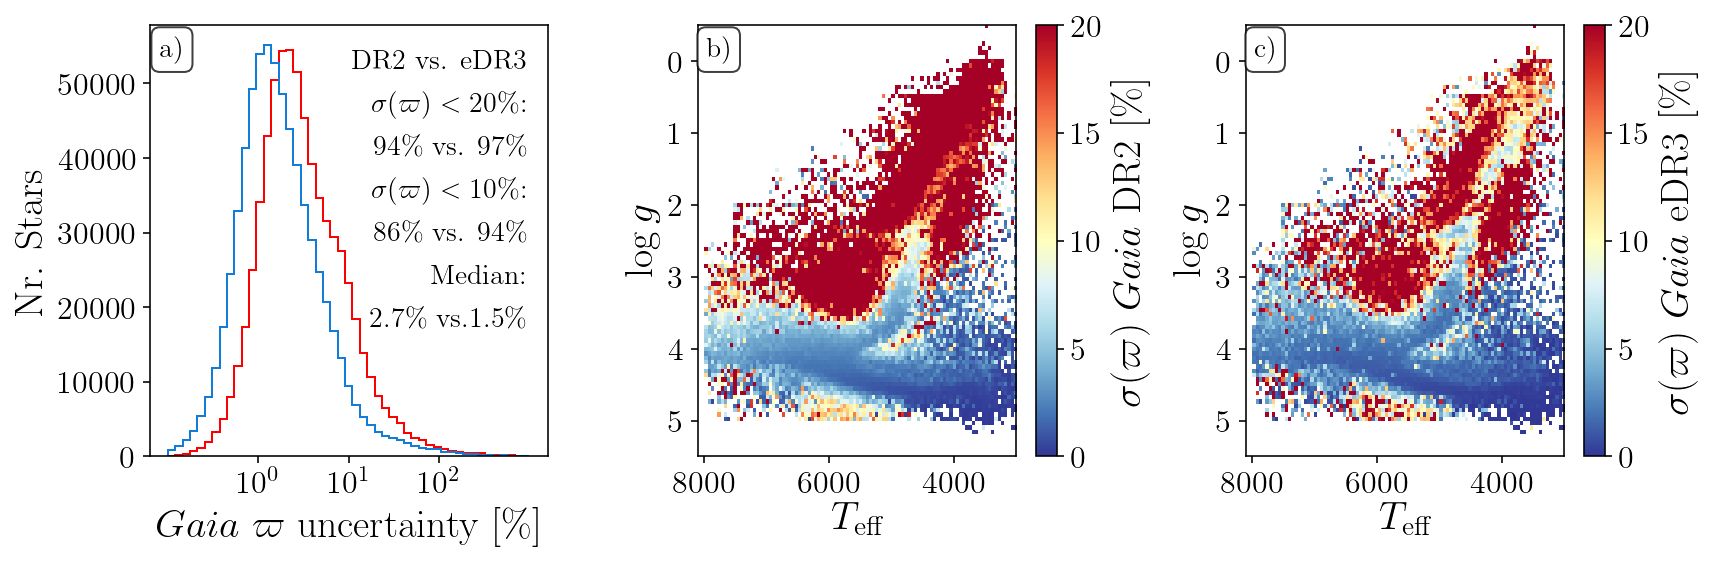

In [9]:
def plot_distance_tefflogg_distance_snr(data, use='_edr3', use_bailerjones=False):
    """
    We plot 3 panels
    a) parallax quality, with bad measurments stacked at 15\% uncertainty
    b) a CMD for Gaia colors
    c) a CMD for 2MASS colors
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
    
    # select stars with finite parallax and Bailer-Jones distance

    finite_parallax = (
        np.isfinite(data['parallax'+use]) & 
        (data['parallax'+use]!=0.) & 
        np.isfinite(data['r_est'])
        )

    # Only a small portion of the parallaxes are bad. We are thus stacking those with uncertainties above 15\% at the end
    plx_uncertainty_dr2 = np.array(100.*np.abs(data['parallax_error_dr2'][finite_parallax]/data['parallax_dr2'][finite_parallax]))
    plx_uncertainty_edr3 = np.array(100.*np.abs(data['parallax_error_edr3'][finite_parallax]/data['parallax_edr3'][finite_parallax]))

    ax1.hist(
        plx_uncertainty_dr2,rasterized=True,
        bins=np.logspace(-1,3,50),histtype='step',ec='r',zorder=2,label='Gaia DR2'
        )

    ax1.hist(
        plx_uncertainty_edr3,rasterized=True,
        bins=np.logspace(-1,3,50),color=willi_blau,histtype='step',ec=willi_blau,zorder=2,label='Gaia eDR3'
        )

    ax1.set_xscale('log')
    ax1.set_ylabel('Nr. Stars')
    ax1.set_xlabel(r'$Gaia$ $\varpi$ uncertainty [\%]')

    below_20perc_dr2 = str(int(np.round(100.*len(plx_uncertainty_dr2[plx_uncertainty_dr2 < 20])/len(plx_uncertainty_dr2),0)))
    below_20perc_edr3 = str(int(np.round(100.*len(plx_uncertainty_edr3[plx_uncertainty_edr3 < 20])/len(plx_uncertainty_edr3),0)))
    below_10perc_dr2 = str(int(np.round(100.*len(plx_uncertainty_dr2[plx_uncertainty_dr2 < 10])/len(plx_uncertainty_dr2),0)))
    below_10perc_edr3 = str(int(np.round(100.*len(plx_uncertainty_edr3[plx_uncertainty_edr3 < 10])/len(plx_uncertainty_edr3),0)))

    
    ax1.text(0.95,0.9,r'DR2 vs. eDR3',transform=ax1.transAxes,ha='right',fontsize=14)
    ax1.text(0.95,0.8,r'$\sigma(\varpi) < 20\%$:',transform=ax1.transAxes,ha='right',fontsize=14)
    ax1.text(0.95,0.7,below_20perc_dr2+r'\% vs. '+below_20perc_edr3+r'\%',transform=ax1.transAxes,ha='right',fontsize=14)
    ax1.text(0.95,0.6,r'$\sigma(\varpi) < 10\%$:',transform=ax1.transAxes,ha='right',fontsize=14)
    ax1.text(0.95,0.5,below_10perc_dr2+r'\% vs. '+below_10perc_edr3+r'\%',transform=ax1.transAxes,ha='right',fontsize=14)
    ax1.text(0.95,0.4,r'Median:',transform=ax1.transAxes,ha='right',fontsize=14)
    ax1.text(0.95,0.3,"{:.1f}".format(np.median(plx_uncertainty_dr2))+r'\% vs.'+"{:.1f}".format(np.median(plx_uncertainty_edr3))+r'\%',transform=ax1.transAxes,ha='right',fontsize=14)

    
    teff_bins = (3000,8100)
    logg_bins = (-0.5,5.5)
    
    hist_kwargs_mean_value = dict(
        reduce_fn='mean',
        bins = (
            np.linspace(teff_bins[0],teff_bins[1],100),
            np.linspace(logg_bins[0],logg_bins[1],100),
        ),
        cmin = 1,
        rasterized = True,
        zorder=2
    )
    

    finite_parallax = (
        np.isfinite(data['parallax_dr2']) & 
        (data['parallax_dr2']!=0.) & 
        np.isfinite(data['parallax_edr3']) & 
        (data['parallax_edr3']!=0.) & 
        np.isfinite(data['r_est'])
        )

    s2 = plot_density(
        data['teff'][finite_parallax],
        data['logg'][finite_parallax],
        weights = plx_uncertainty_dr2,
        ax = ax2,vmin=0,vmax=20,
        **hist_kwargs_mean_value
        )
    
    c2 = plt.colorbar(s2,ax=ax2)
    c2.set_label(r'$\sigma(\varpi)$ $Gaia$ DR2 [\%]')

    s3 = plot_density(
        data['teff'][finite_parallax],
        data['logg'][finite_parallax],
        weights = plx_uncertainty_edr3,
        ax = ax3,vmin=0,vmax=20,
        **hist_kwargs_mean_value
        )
    
    c3 = plt.colorbar(s3,ax=ax3)
    c3.set_label(r'$\sigma(\varpi)$ $Gaia$ eDR3 [\%]')
    
    ax2.set_xlabel(r'$T_\text{eff}$')
    ax2.set_ylabel(r'$\log g$')
    ax2.set_xlim(teff_bins[1],teff_bins[0])
    ax2.set_ylim(logg_bins[1],logg_bins[0])
    ax3.set_xlabel(r'$T_\text{eff}$')
    ax3.set_ylabel(r'$\log g$')
    ax3.set_xlim(teff_bins[1],teff_bins[0])
    ax3.set_ylim(logg_bins[1],logg_bins[0])


    props = dict(boxstyle='round', facecolor='w', alpha=0.75)
    ax1.text(0.025, 0.975, 'a)', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ax2.text(0.025, 0.975, 'b)', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    ax3.text(0.025, 0.975, 'c)', transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    ax1.set_xticks([1,10,100])
    plt.tight_layout(h_pad=0)

    return(fig)

fig = plot_distance_tefflogg_distance_snr(data=galah_dr3_gaia_edr3)

plt.savefig('galah_plx_gaiadr2edr3.png',dpi=200,bbox_inches='tight')